In [1]:
# Libraries
#%load_ext autoreload
#%autoreload 2

#import sys; sys.path.insert(0, '..')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

sns.set()

# Data Generation

## Scenario 1: Constant Effect

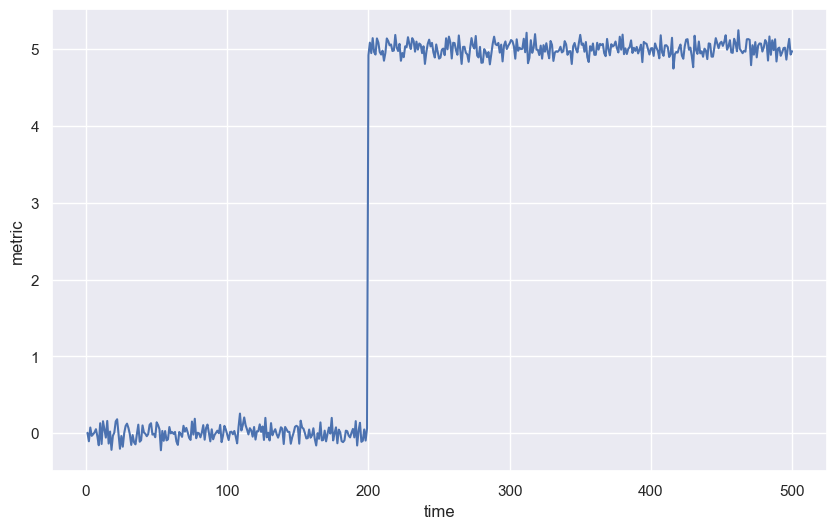

In [2]:
y = np.random.normal(scale=0.1, size=500)
t = np.arange(1, len(y)+1)

y = np.where(t>=200, y+5, y)
s = pd.DataFrame({'time':t, 'metric':y})

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='metric', data=s)
plt.show()

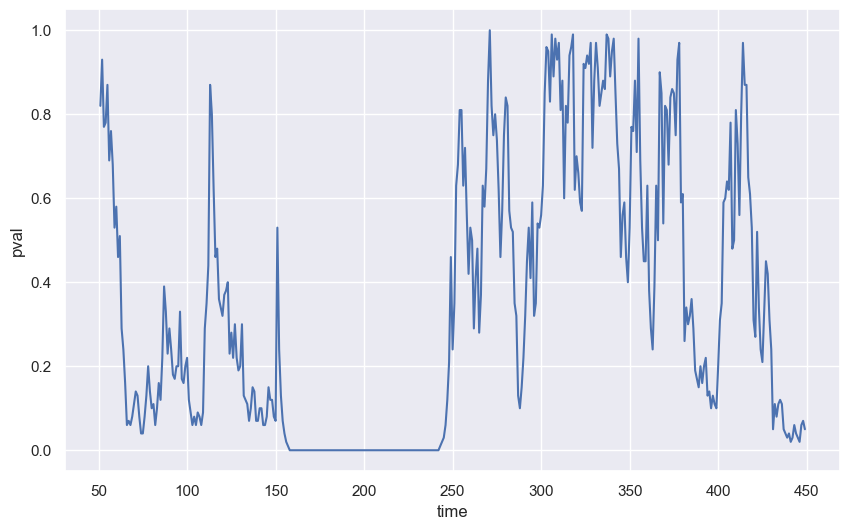

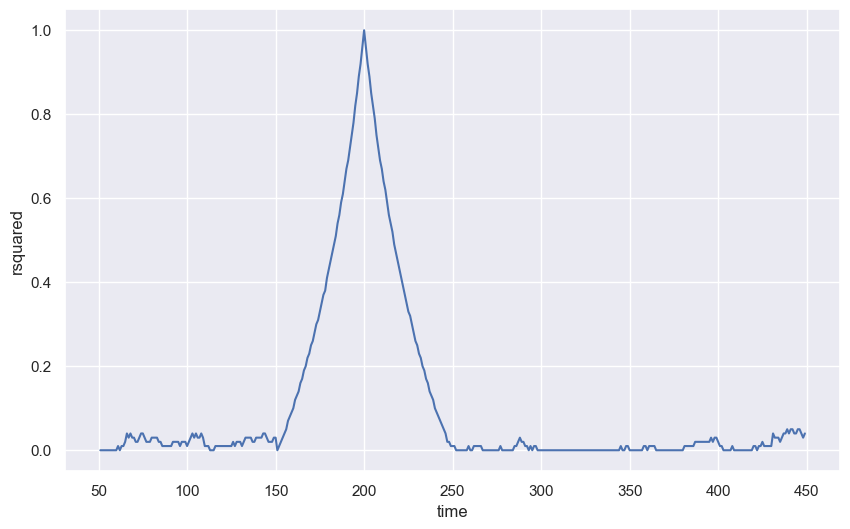

In [3]:
min_periods = 50
results = {'time':[], 'coef':[], 'pval':[], 'rsquared':[]}
for t in range(1, len(s)+1):
    if t>min_periods and t<len(s)-min_periods:
        tmp = s[(s.time >= t - min_periods) & (s.time < t + min_periods)].copy()
        tmp['event'] = np.where(tmp.time>=t, 1, 0)
        model = smf.ols(formula='metric ~ C(event)', data=tmp).fit()
        results['time'].append(t)
        results['coef'].append(model.params['C(event)[T.1]'])
        results['pval'].append(model.pvalues['C(event)[T.1]'])
        results['rsquared'].append(model.rsquared)

results = pd.DataFrame(results)

results['weighted_coef'] = (1 - results['pval'])*results['coef']*results['rsquared']
maxindex = results['weighted_coef'].idxmax()

opt_res = results.iloc[[maxindex]]

for col in ['coef', 'pval', 'weighted_coef', 'rsquared']:
    results[col] = results[col].round(2)

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='pval', data=results)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='rsquared', data=results)
plt.show()

### Point that maximises weighted (by rsquared) coef

In [4]:
opt_res

,time,coef,pval,rsquared,weighted_coef
149,200,5.026698,9.118551e-145,0.99879,5.020616


                            OLS Regression Results                            
Dep. Variable:                 metric   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 3.611e+05
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:19:30   Log-Likelihood:                 488.90
No. Observations:                 500   AIC:                            -973.8
Df Residuals:                     498   BIC:                            -965.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0013      0.006      0.199      0.8

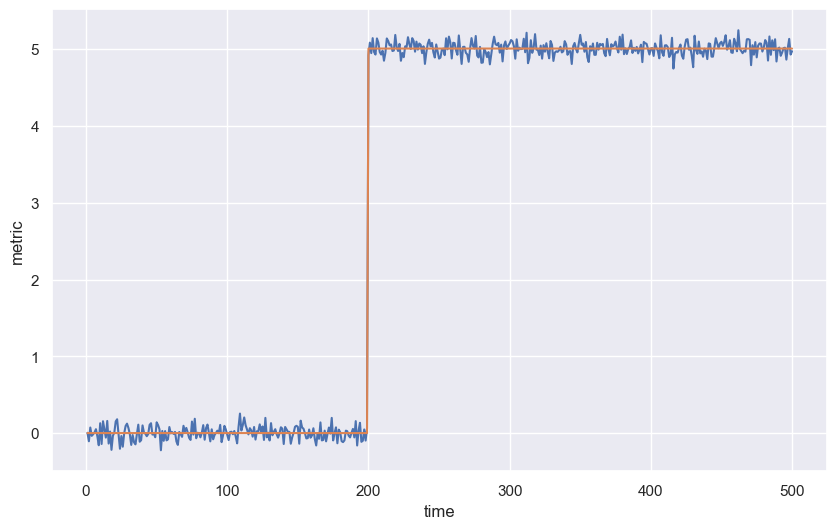

In [5]:
ms = s.copy()
evdate = opt_res.time.values[0]

ms['event'] = np.where(ms.time>=evdate, 1, 0)
model = smf.ols(formula='metric ~ event', data=ms).fit()
ms['fitted_metric'] = model.predict(ms)
print(model.summary())

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='metric', data=ms)
sns.lineplot(x='time', y='fitted_metric', data=ms)
plt.show()

## Scenario 2: Diminishing Effect

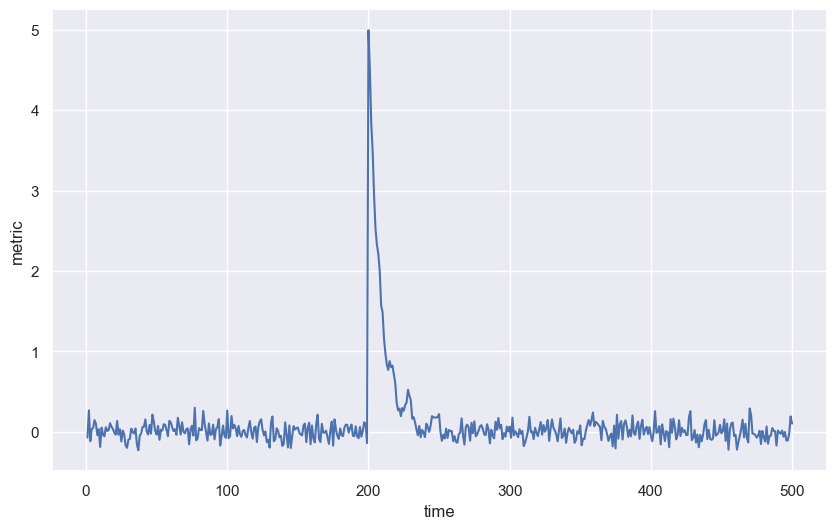

In [6]:
def geometric_adstock(series, decay, event_time, max_effect_time):
    adstock_series = np.zeros_like(series, dtype=float)
    for t in range(len(series)):
        adstock_series[t] = series[t] + (decay * adstock_series[t-1] if t >= event_time and t <max_effect_time else 0)    
    return adstock_series

y = np.random.normal(loc=0, scale=0.1, size=500)
t = np.arange(1, len(y)+1)

event_time=200
max_effect_time=250
decay = 0.9
y = np.where(t==event_time, y+5, y)
y = geometric_adstock(y, decay, event_time, max_effect_time)
s = pd.DataFrame({'time':t, 'metric':y})

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='metric', data=s)
plt.show()

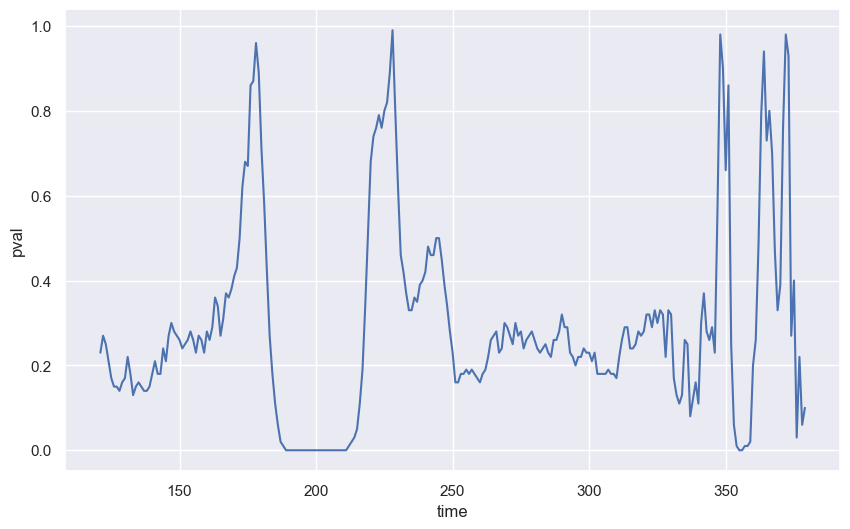

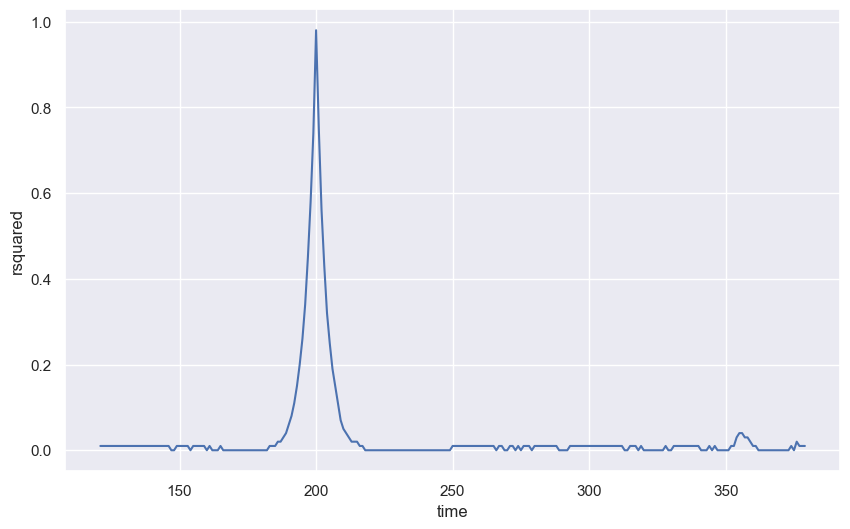

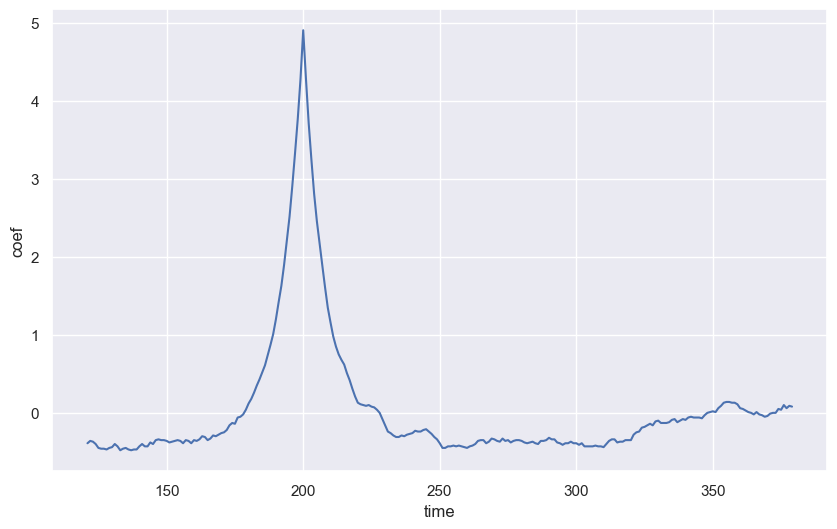

In [7]:
min_periods = 120
l=0.12
results = {'time':[], 'coef':[], 'pval':[], 'rsquared':[]}
for t in range(1, len(s)+1):
    if t>min_periods and t<len(s)-min_periods:
        tmp = s[(s.time >= t - min_periods) & (s.time < t + min_periods)].copy()
        tmp['event'] = np.where(tmp.time>=t, 1, 0)
        tmp['time_from_event'] = np.where(tmp.time>t, tmp.time-t, 0)

        model = smf.ols(formula='metric ~ event:np.exp(-l*time_from_event)', data=tmp).fit()
        results['time'].append(t)
        results['coef'].append(model.params['event:np.exp(-l * time_from_event)'])
        results['pval'].append(model.pvalues['event:np.exp(-l * time_from_event)'])
        results['rsquared'].append(model.rsquared)

results = pd.DataFrame(results)

results['weighted_coef'] = (1 - results['pval'])*results['coef']*results['rsquared']
maxindex = results['weighted_coef'].idxmax()
opt_res = results.iloc[[maxindex]]

for col in ['coef', 'pval', 'weighted_coef', 'rsquared']:
    results[col] = results[col].round(2)

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='pval', data=results)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='rsquared', data=results)
plt.show()

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='coef', data=results)
plt.show()

### Identifying the point that maximises R2, coef

In [8]:
opt_res

,time,coef,pval,rsquared,weighted_coef
79,200,4.905216,1.686768e-195,0.97634,4.789157


                            OLS Regression Results                            
Dep. Variable:                 metric   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                 1.045e+04
Date:                Mon, 28 Oct 2024   Prob (F-statistic):               0.00
Time:                        11:19:31   Log-Likelihood:                 432.30
No. Observations:                 500   AIC:                            -860.6
Df Residuals:                     498   BIC:                            -852.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

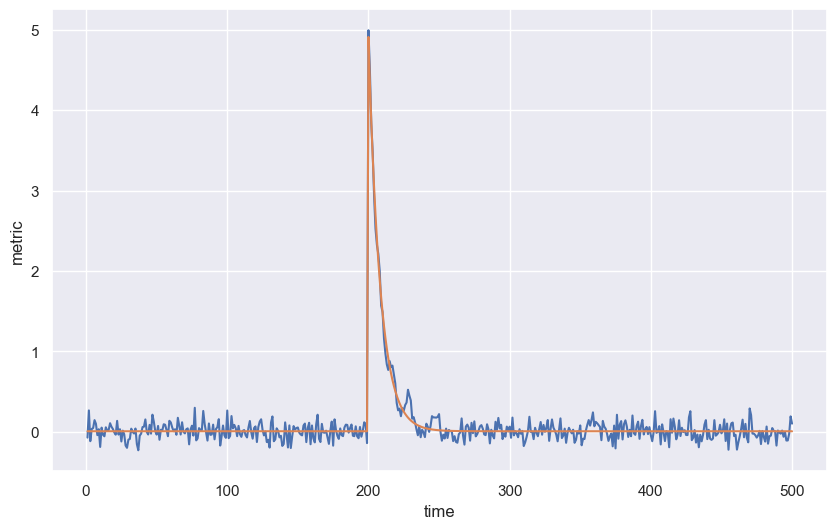

In [9]:
ms = s.copy()
evdate = opt_res.time.values[0]
l=0.12

ms['event'] = np.where(ms.time>=evdate, 1, 0)
ms['time_from_event'] = np.where(ms.time>evdate, evdate-ms.time, 0)
model = smf.ols(formula='metric ~ event:np.exp(l*time_from_event)', data=ms).fit()
ms['fitted_metric'] = model.predict(ms)
print(model.summary())

plt.figure(figsize=(10,6))
sns.lineplot(x='time', y='metric', data=ms)
sns.lineplot(x='time', y='fitted_metric', data=ms)
plt.show()